### Section A/B

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

inv = np.linalg.inv

def rbf(x1, x2, tau):
    return np.exp(
        -np.power((x1[:, None] - x2[None, :]), 2).sum(axis=2) / 
            (2* tau ** 2)
    )

class KernelRidge:
    """"""
    def __init__(self, kernel='RBF', tau=1.0, lambda_=1.0):
        if kernel == "RBF":
            self.kernel = rbf
            self.kernel_kwargs = {"tau": tau}
            self.lambda_ = lambda_
        else:
            raise RuntimeError("Kernel not yet implemented. Choose one of: ['RBF']")
        # assembled later
        self.G = None # Gram matrix
        self.alpha = None # weights
        self.X = None
        self.Ybar = None
        self.scaler = StandardScaler()
        
            
    def construct_gram_matrix(self, X):
        """
        Constructs a Gram matrix for a given X
        """
        self.X = self.scaler.fit_transform(X)
        self.G = self.kernel(self.X, self.X, **self.kernel_kwargs)
        
    def fit(self, X, Y):
        """
        Fits the kernel regression
        """
        assert X.shape[0] == Y.shape[0]
        self.Ybar = np.mean(Y)
        self.Y_ = Y - np.mean(Y)
        self.construct_gram_matrix(X)
        self.alpha = inv(self.G + self.lambda_ * np.eye(X.shape[0])) @ self.Y_
        
    def predict(self, X):
        """
        Predicts for a new X
        """
        Z = self.scaler.transform(X)
        g_hat = self.kernel(Z, self.X, **self.kernel_kwargs)
        return self.Ybar + g_hat @ self.alpha
    
    def predict_insample(self):
        """
        Predicts for in-sample yhats. Mostly for testing .predict()
        """
        return (
            self.Ybar + self.G @ self.alpha, 
            self.Ybar + self.G @ inv(self.G + self.lambda_ * np.eye(X.shape[0])) @ self.Y_,
            self.Ybar + inv(self.G + self.lambda_ * np.eye(X.shape[0])) @ self.G @ self.Y_
        )
    
    
    
    
def do_2c(lambda_, tau, features):
    model_2c = KernelRidge(tau=tau, lambda_=lambda_)
    model_2c.fit(X=data[features].values, Y=data.lpsa.values)
    yhat = model_2c.predict(X=data[features].values)

    plt.scatter(data.lcavol.values, data.lpsa.values, label="Observed", alpha=.5)
    plt.scatter(data.lcavol.values, yhat, label="Predicted", alpha=.5)
    plt.legend()
    plt.xlabel("lcavol")
    plt.ylabel("lpsa")
    plt.title(f"$ t$ = {model_2c.kernel_kwargs['tau']} || $\lambda$ = {model_2c.lambda_} ")
    plt.show()

data = pd.read_csv("/Users/IKleisle/Stanford/STATS305A/lprostate.csv").iloc[:, 2:]
data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.5798,2.7695,50,-1.3863,0,-1.3863,6,0,-0.4308
1,-0.9943,3.3196,58,-1.3863,0,-1.3863,6,0,-0.1625
2,-0.5108,2.6912,74,-1.3863,0,-1.3863,7,20,-0.1625
3,-1.2040,3.2828,58,-1.3863,0,-1.3863,6,0,-0.1625
4,0.7514,3.4324,62,-1.3863,0,-1.3863,6,0,0.3716


### Section C

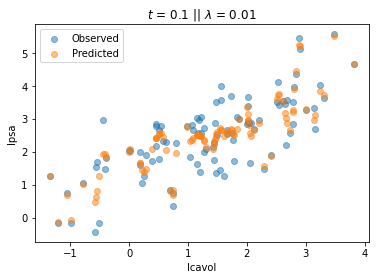

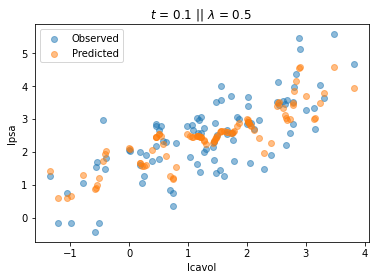

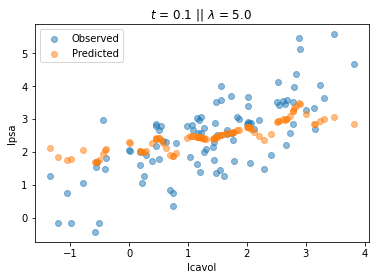

In [2]:
for lam in [1e-2, 5e-1, 5.]:
    do_2c(lam, 1e-1, ["lcavol"])

Here, we see that as $\lambda$ increases, the "slope" flattens out, i.e. the kernel regressor centers increasingly on the mean. After all, with a greater. $\lambda$, it's more heavily regularized, so this is to be expected -- were quickly decreasing variance but increasing bias.

### Section D

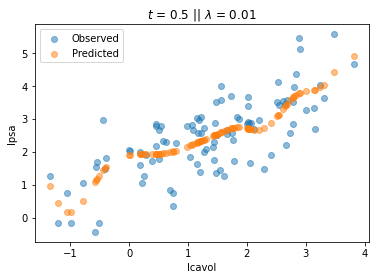

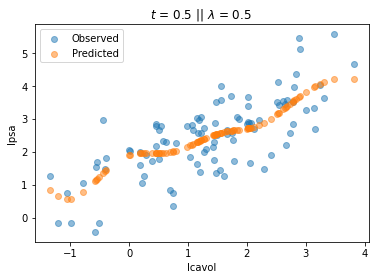

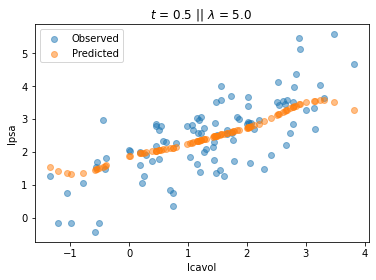

In [3]:
for lam in [1e-2, 5e-1, 5.]:
    do_2c(lam, 5e-1, ["lcavol"])

With $\tau=.5$, the "flattening" of the predictions induced by increasing $\lambda$ is still present, but not to the extent it was in part c. The larger bandwidth here allows for a less flexible fit -- this comports with 2D, where we showed that as $tau \to 0$, the fit increasingly mirrors the data. 

### Section E

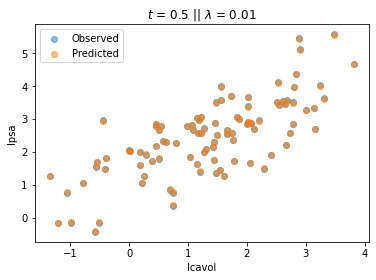

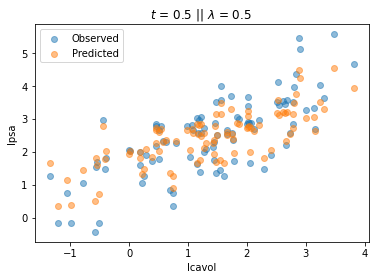

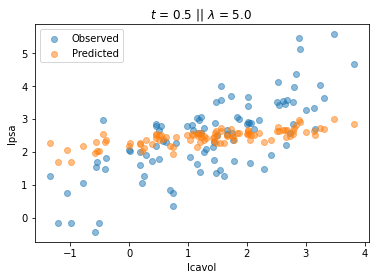

In [4]:
for lam in [1e-2, 5e-1, 5.]:
    do_2c(lam, 5e-1, [item for item in data.columns if item != "lpsa"])

In the less-regularized setting (i.e. $\lambda \approx .01$), we see a near memorization/overfit of the data. This makes sense -- we threw a lot more features at the model, didn't really penalize, and so it overfit. In the second model, things look to be appropriately regularized, as predictions and observations generally align. Lastly, in the $\lambda=5$ case, the strong regularization seems to shrink/"flatten" all of the coefficients such that predictions are not far off from the mean of the training response. 

### Section F

In [5]:
# first part of problem

def get_sigma(X, Y, tau, lambda_):
    """
    As instructed in problem F
    """
    
    

    temp_kernel = KernelRidge(kernel='RBF', tau=tau, lambda_=lambda_)
    temp_kernel.construct_gram_matrix(X)
    temp_kernel.fit(X=X, Y=Y)

    # number of data points
    N = temp_kernel.X.shape[0]
    # Hat matrix
    H_lam = temp_kernel.G @ np.linalg.inv(temp_kernel.G + temp_kernel.lambda_ * np.eye(N))
    # yhat
    yhat = temp_kernel.predict(X)
    # final result
    sigma_hat = ((yhat - Y).T @ (yhat - Y))/ (
        (N - 2 * np.trace(H_lam) + np.trace(H_lam @ H_lam))
    )
    return sigma_hat

sigma_hat = get_sigma(
    data[[item for item in data.columns if item != 'lpsa']].values, 
    data.lpsa.values, 
    tau=.5, 
    lambda_=.1
)
sigma_hat

0.6335306285119595

For the full regression, $\hat\sigma^2$ worked out to ~.63353.

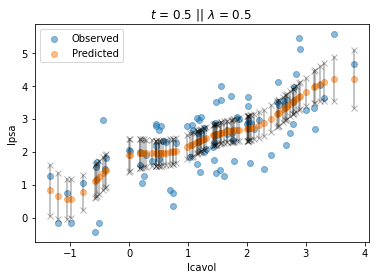

In [6]:
model_2f = KernelRidge(tau=5e-1, lambda_=5e-1)
model_2f.fit(X=data[["lcavol"]].values, Y=data.lpsa.values)
yhat = model_2f.predict(X=data[["lcavol"]].values)


# sigma_hat = get_sigma(X=data[["lcavol"]].values, Y=data.lpsa.values, tau=.5, lambda_=.5)
Hl = inv(model_2f.G + model_2f.lambda_ * np.eye(model_2f.G.shape[0])) @ model_2f.G
std_errs = np.sqrt(sigma_hat * np.diag(Hl @ Hl.T))


for (i, err) in enumerate(std_errs):
    plt.plot(
        [data.lcavol.values[i], data.lcavol.values[i]], 
        [yhat[i] - 2 * err, yhat[i] + 2 * err],
        marker='x', 
        alpha=.3,
        color='black'
)

plt.scatter(data.lcavol.values, data.lpsa.values, label="Observed", alpha=.5)
plt.scatter(data.lcavol.values, yhat, label="Predicted", alpha=.5)
plt.legend()
plt.xlabel("lcavol")
plt.ylabel("lpsa")
plt.title(f"$ t$ = {model_2f.kernel_kwargs['tau']} || $\lambda$ = {model_2f.lambda_} ")
plt.show()


Standard error was computed by taking $\sqrt{diag(\hat\sigma^2 H_\lambda H_\lambda^T)}$, with $\hat\sigma^2$ as calculated "in full" in the first part of the problem, via the first formula given on the HW sheet.